In [163]:
from selenium import webdriver
from bs4 import BeautifulSoup
import zipfile
import pandas as pd
from io import StringIO
import requests
import csv
import time
import random

# Creating Dataframe

In [164]:
#pip import xlrx (Python Library extract Excel spreadsheets)

Indiana_url = "https://hub.mph.in.gov/dataset/62ddcb15-bbe8-477b-bb2e-175ee5af8629/resource/2538d7f1-391b-4733-90b3-9e95cd5f3ea6/download/covid_report_demographics.xlsx"
Indiana_totals="https://hub.mph.in.gov/dataset/ab9d97ab-84e3-4c19-97f8-af045ee51882/resource/182b6742-edac-442d-8eeb-62f96b17773e/download/covid_report_date.xlsx"

#historical data for cases and deaths
Indiana_historical = pd.read_excel(Indiana_totals, "Report")

#takes data from the "Race" tab in the spreadsheet
Indiana_race = pd.read_excel(Indiana_url, "Race")

#takes data from the "Ethnicity" tab in the spreadsheet
Indiana_ethnicity = pd.read_excel(Indiana_url, "Ethnicity")

# Data Cleaning

In [165]:
#delete columns which are not used for COVID Racial Data Tracker
Indiana_historical = Indiana_historical[['DATE','COVID_COUNT_CUMSUM','COVID_DEATHS_CUMSUM','COVID_TEST_CUMSUM']]
Indiana_race = Indiana_race.drop(['COVID_TEST_PCT','COVID_COUNT_PCT','COVID_DEATHS_PCT'], 1)
Indiana_ethnicity = Indiana_ethnicity.drop(['COVID_TEST_PCT','COVID_COUNT_PCT','COVID_DEATHS_PCT'], 1)

#renames COVID_COUNT to cases
Indiana_historical.rename(columns = {'COVID_COUNT_CUMSUM':'Cases'}, inplace = True)
Indiana_historical.rename(columns = {'COVID_DEATHS_CUMSUM':'Deaths'}, inplace = True)
Indiana_historical.rename(columns = {'COVID_TEST_CUMSUM':'Tests'}, inplace = True)
Indiana_race.rename(columns = {'COVID_COUNT':'Cases'}, inplace = True)
Indiana_race.rename(columns = {'COVID_TEST':'Tests'}, inplace = True)
Indiana_race.rename(columns = {'COVID_DEATHS':'Deaths'}, inplace = True)
Indiana_ethnicity.rename(columns = {'COVID_COUNT':'Cases'}, inplace = True)
Indiana_ethnicity.rename(columns = {'COVID_TEST':'Tests'}, inplace = True)
Indiana_ethnicity.rename(columns = {'COVID_DEATHS':'Deaths'}, inplace = True)

# #repositioning columns for IN
Indiana_race = Indiana_race[['RACE', 'Cases', 'Deaths', 'Tests']]
Indiana_race.set_index('RACE', inplace=True)

# #repositioning columns for GA
Indiana_ethnicity = Indiana_ethnicity[['ETHNICITY', 'Cases', 'Deaths', 'Tests']]
Indiana_ethnicity.set_index('ETHNICITY', inplace=True)

#reformatting so all column headers are on same row
Indiana_race.columns.name = Indiana_race.index.name
Indiana_race.index.name = None

Indiana_ethnicity.columns.name = Indiana_ethnicity.index.name
Indiana_ethnicity.index.name = None

In [168]:
Indiana_historical['DATE']=pd.to_datetime(Indiana_historical['DATE'],format='%Y-%m-%d')
Indiana_today=Indiana_historical.tail(1).reset_index()
del Indiana_today['index']
Indiana_today

,DATE,Cases,Deaths,Tests
0,2020-11-08,214509,4418,1823029


# Indiana Race Dataframe

In [169]:
Indiana_race

RACE,Cases,Deaths,Tests
Asian,2662,23,33105
Black or African American,16131,493,138258
Other Race,26325,596,214508
Unknown,41032,298,242681
White,128359,3008,1194477


# Indiana Ethnicity Dataframe

In [170]:
Indiana_ethnicity

ETHNICITY,Cases,Deaths,Tests
Hispanic or Latino,16117,113,65772
Not Hispanic or Latino,92754,2243,791686
Unknown,105638,2062,965571


# Data Validation

In [171]:
#Difference in sum of cases by race v. Total confirmed cases 
race_v_cases=int(Indiana_historical["Cases"].tail(1)-Indiana_race["Cases"].sum())

#Difference in sum of cases by ethnicity v. Total cases 
ethnicity_v_cases=int(Indiana_historical["Cases"].tail(1)-Indiana_ethnicity["Cases"].sum())

#Difference in sum of deaths by race v. Total deaths
race_v_deaths=int(Indiana_historical["Deaths"].tail(1)-Indiana_race["Deaths"].sum())

#Difference in sum of deaths by ethnicity v. Total deaths
ethnicity_v_deaths=int(Indiana_historical["Deaths"].tail(1)-Indiana_ethnicity["Deaths"].sum())

#Difference in sum of tests by race v. Total individuals tested
race_v_tests=int(Indiana_historical["Tests"].tail(1)-Indiana_race["Tests"].sum())

#Difference in sum of tests by ethnicity v. Total individuals tested
ethnicity_v_tests=int(Indiana_historical["Tests"].tail(1)-Indiana_ethnicity["Tests"].sum())

data_validation= pd.DataFrame({"Difference in sum of cases by race v. Total confirmed cases":[race_v_cases], 
    "Difference in sum of cases by ethnicity v. Total cases":[ethnicity_v_cases],
    "Difference in sum of deaths by race v. Total deaths":[race_v_deaths],
    "Difference in sum of deaths by ethnicity v. Total deaths":[ethnicity_v_deaths],
    "Difference in sum of tests by race v. Total individuals tested":[race_v_tests],
    "Difference in sum of tests by ethnicity v. Total individuals tested":[ethnicity_v_tests]},index=['Data Validation']).T


#Red if values are not equal
data_validation.style.applymap(lambda x: 'background-color : red' if x!=0 else '')

,Data Validation
Difference in sum of cases by race v. Total confirmed cases,0
Difference in sum of cases by ethnicity v. Total cases,0
Difference in sum of deaths by race v. Total deaths,0
Difference in sum of deaths by ethnicity v. Total deaths,0
Difference in sum of tests by race v. Total individuals tested,0
Difference in sum of tests by ethnicity v. Total individuals tested,0


# Historical Indiana Data from CRDT Website

In [172]:
#get data from CRDT website
CRDT_data = "https://docs.google.com/spreadsheets/d/e/2PACX-1vR_xmYt4ACPDZCDJcY12kCiMiH0ODyx3E1ZvgOHB8ae1tRcjXbs_yWBOA4j4uoCEADVfC1PS2jYO68B/pub?gid=43720681&single=true&output=csv"
df=pd.read_csv(CRDT_data)

#convert data column to datetime data-type
df['Date']= pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')

#filter for Georgia data only and re-index
Indiana_CRDT=df.loc[df['State']=='IN'].reset_index()
Indiana_CRDT.drop('State', inplace=True, axis=1)
del Indiana_CRDT['index']

#only display 5 most recent records (takes about 15 seconds to load)
Indiana_CRDT.head(5)

,Date,Cases_Total,Cases_White,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,Cases_Other,...,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown,Deaths_Ethnicity_Hispanic,Deaths_Ethnicity_NonHispanic,Deaths_Ethnicity_Unknown
0,2020-11-08,210374,125822,15948.0,NaN,2604.0,NaN,NaN,NaN,26018.0,...,NaN,23.0,NaN,NaN,NaN,590.0,539.0,113.0,2224.0,2292.0
1,2020-11-04,191764,114608,15230.0,NaN,2364.0,NaN,NaN,NaN,24598.0,...,NaN,23.0,NaN,NaN,NaN,576.0,518.0,107.0,2135.0,2222.0
2,2020-11-01,182108,106869,14656.0,NaN,2217.0,NaN,NaN,NaN,23612.0,...,NaN,22.0,NaN,NaN,NaN,561.0,525.0,104.0,2079.0,2181.0
3,2020-10-28,169112,99145,14127.0,NaN,2052.0,NaN,NaN,NaN,22606.0,...,NaN,22.0,NaN,NaN,NaN,540.0,507.0,101.0,1999.0,2127.0
4,2020-10-25,162607,93614,13718.0,NaN,1968.0,NaN,NaN,NaN,21850.0,...,NaN,22.0,NaN,NaN,NaN,531.0,511.0,99.0,1946.0,2085.0


# Converting New Scraped Covid Data into Same Format as CRDT Table

In [173]:
column_names = ["Date","Cases_Total","Cases_White","Cases_Black","Cases_LatinX","Cases_Asian",
                "Cases_AIAN","Cases_NHPI","Cases_Multiracial","Cases_Other","Cases_Unknown",
                "Cases_Ethnicity_Hispanic","Cases_Ethnicity_NonHispanic","Cases_Ethnicity_Unknown",
                "Deaths_Total","Deaths_White","Deaths_Black","Deaths_LatinX","Deaths_Asian",
               "Deaths_AIAN","Deaths_NHPI","Deaths_Multiracial","Deaths_Other","Deaths_Unknown",
               "Deaths_Ethnicity_Hispanic","Deaths_Ethnicity_NonHispanic","Deaths_Ethnicity_Unknown"]

#new_data is the dataframe for the new data which you just scraped converted into data format of Indiana_CRDT
new_data = pd.DataFrame(columns = column_names)

new_data["Date"]=[Indiana_today.loc[0,"DATE"]]
new_data["Cases_Total"]=[Indiana_today.loc[0,"Cases"]]
new_data["Cases_White"]=[Indiana_race.loc["White","Cases"]]
new_data["Cases_Black"]=[Indiana_race.loc["Black or African American","Cases"]]
new_data["Cases_Asian"]=[Indiana_race.loc["Asian","Cases"]]
new_data["Cases_Other"]=[Indiana_race.loc["Other Race","Cases"]]
new_data["Cases_Unknown"]=[Indiana_race.loc["Unknown","Cases"]]
new_data["Cases_Ethnicity_Hispanic"]=[Indiana_ethnicity.loc["Hispanic or Latino","Cases"]]
new_data["Cases_Ethnicity_NonHispanic"]=[Indiana_ethnicity.loc["Not Hispanic or Latino","Cases"]]
new_data["Cases_Ethnicity_Unknown"]=[Indiana_ethnicity.loc["Unknown","Cases"]]

new_data["Deaths_Total"]=[Indiana_today.loc[0,"Deaths"]]
new_data["Deaths_White"]=[Indiana_race.loc["White","Deaths"]]
new_data["Deaths_Black"]=[Indiana_race.loc["Black or African American","Deaths"]]
new_data["Deaths_Asian"]=[Indiana_race.loc["Asian","Deaths"]]
new_data["Deaths_Other"]=[Indiana_race.loc["Other Race","Deaths"]]
new_data["Deaths_Unknown"]=[Indiana_race.loc["Unknown","Deaths"]]
new_data["Deaths_Ethnicity_Hispanic"]=[Indiana_ethnicity.loc["Hispanic or Latino","Deaths"]]
new_data["Deaths_Ethnicity_NonHispanic"]=[Indiana_ethnicity.loc["Not Hispanic or Latino","Deaths"]]
new_data["Deaths_Ethnicity_Unknown"]=[Indiana_ethnicity.loc["Unknown","Deaths"]]

new_data.T

,0
Date,2020-11-08 00:00:00
Cases_Total,214509
Cases_White,128359
Cases_Black,16131
Cases_LatinX,NaN
Cases_Asian,2662
Cases_AIAN,NaN
Cases_NHPI,NaN
Cases_Multiracial,NaN
Cases_Other,26325


# Appending the New Scraped Data to CRDT Indiana Historical Data

In [174]:
#Indiana_Last is the data from the CRDT IN Historical data which you want to compare with new scraped data in time series

#Because CRDT are every Wednesday and Sunday Night. 
#So if you are running the Scrpaer on a Wednesday or Sunday Night, 
    #there will be zero difference in new scraped data and historical data from CRDT
    #So I put the second most recent data for scrpaer to compare with as a way to avoid getting zero. 
    
Indiana_Last_Shift=Indiana_CRDT.loc[[1]] #.loc[[0]] means most recent data in CRDT, .loc[[1]] second most recent data
#You should adjust the .loc[[0]] or .loc[[1]] depending on what day or time you are running the scaper.

#Append the new scraped data and historical data.
append_data=Indiana_Last_Shift.append(new_data, ignore_index=True)

#Set index as date and all datatype as a number. 
append_data.set_index('Date', inplace=True)
append_data=append_data.astype('float64')

append_data

,Cases_Total,Cases_White,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,Cases_Other,Cases_Unknown,...,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown,Deaths_Ethnicity_Hispanic,Deaths_Ethnicity_NonHispanic,Deaths_Ethnicity_Unknown
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-04,191764.0,114608.0,15230.0,NaN,2364.0,NaN,NaN,NaN,24598.0,34964.0,...,NaN,23.0,NaN,NaN,NaN,576.0,518.0,107.0,2135.0,2222.0
2020-11-08,214509.0,128359.0,16131.0,NaN,2662.0,NaN,NaN,NaN,26325.0,41032.0,...,NaN,23.0,NaN,NaN,NaN,596.0,298.0,113.0,2243.0,2062.0


# Time Series Diffs Check (amount by which each category increased)

In [175]:
#This data quality checker is to simulate the first tab of the Google Sheet used by CRDT for TimeSeries checks. 

# the .T means transpose, so that it is easier to read. If you do not want to transpose, simply delete the .T
diffs = append_data.diff().T

#Orange cells means the category has decreased
#Red cells decreased by more than 100
diffs.style.applymap(lambda x: 'background-color : orange' if x<0 and x>-100 else '').\
applymap(lambda x: 'background-color : red' if x<-100 or x==100 else '')

Date,2020-11-04 00:00:00,2020-11-08 00:00:00
Cases_Total,nan,22745.000000
Cases_White,nan,13751.000000
Cases_Black,nan,901.000000
Cases_LatinX,nan,nan
Cases_Asian,nan,298.000000
Cases_AIAN,nan,nan
Cases_NHPI,nan,nan
Cases_Multiracial,nan,nan
Cases_Other,nan,1727.000000
Cases_Unknown,nan,6068.000000


# Time Series %ofSelf Check (percent by which each category has increased)

In [176]:
#This data quality checker is to simulate the second tab of the Google Sheet used by CRDT for TimeSeries checks. 

# the .T means transpose, so that it is easier to read. If you do not want to transpose, simply delete the .T
#The *100 is to go from a decimal to a percentage
perc_diff = append_data.pct_change().T*100

#yellow >25%
#orange >50%
#red >100% doubles
perc_diff.style.applymap(lambda x: 'background-color : yellow' if x>25 and x<50 else '').\
applymap(lambda x: 'background-color : orange' if x>50 and x<100 else '').\
applymap(lambda x: 'background-color : red' if x>100 else '')

Date,2020-11-04 00:00:00,2020-11-08 00:00:00
Cases_Total,nan,11.860933
Cases_White,nan,11.998290
Cases_Black,nan,5.915955
Cases_LatinX,nan,nan
Cases_Asian,nan,12.605753
Cases_AIAN,nan,nan
Cases_NHPI,nan,nan
Cases_Multiracial,nan,nan
Cases_Other,nan,7.020896
Cases_Unknown,nan,17.354994


# Time Series %ofTotal (percent by which percent-of-total that category increased)

In [177]:
#This data quality checker is to simulate the third tab of the Google Sheet used by CRDT for TimeSeries checks. 

#First have to divide up the append_data into 6 different dataframes(Total Cases, Race Cases, Ethnicity Cases...etc)
#Each of the six dataframes should sum up to either to total cases or total deaths. 
#Then can divide each category by the total sum of each category to find the percentage
#Then compare the percentage of total for each category with new data and last first to find percent_difference
#A simple example would be if Total Cases was 1000, then Hispanic cases 200, Non-Hispanic Cases are 500,
    #and unknown ethnicity was 300. Hispanic cases is 20%, Non-Hispanic Cases is 50%, and Unknown is 30%. 
    #then you would compare with the previous shift percentages to determine percentage change. 

#Total Cases
Cases_Total_PCT=append_data[['Cases_Total']].div(append_data[['Cases_Total']].sum(axis=1), axis=0)
Cases_Total_PCT=Cases_Total_PCT.pct_change()*100

#Race Cases
Cases_Race=append_data[['Cases_White','Cases_Black','Cases_LatinX','Cases_Asian','Cases_AIAN',
             'Cases_NHPI','Cases_Multiracial','Cases_Other','Cases_Unknown']]
Cases_Race_PCT = Cases_Race.div(Cases_Race.sum(axis=1), axis=0)
Cases_Race_PCT=Cases_Race_PCT.pct_change()*100

#Ethnicity Cases
Cases_Ethnicity=append_data[["Cases_Ethnicity_Hispanic","Cases_Ethnicity_NonHispanic","Cases_Ethnicity_Unknown"]]
Cases_Ethnicity_PCT = Cases_Ethnicity.div(Cases_Ethnicity.sum(axis=1), axis=0)
Cases_Ethnicity_PCT=Cases_Ethnicity_PCT.pct_change()*100

#Total Deaths 
Deaths_Total_PCT=append_data[['Deaths_Total']].div(append_data[['Deaths_Total']].sum(axis=1), axis=0)
Deaths_Total_PCT=Deaths_Total_PCT.pct_change()*100

#Race Deaths
Deaths_Race=append_data[['Deaths_White','Deaths_Black','Deaths_LatinX','Deaths_Asian','Deaths_AIAN',
             'Deaths_NHPI','Deaths_Multiracial','Deaths_Other','Deaths_Unknown']]
Deaths_Race_PCT = Deaths_Race.div(Deaths_Race.sum(axis=1), axis=0)
Deaths_Race_PCT=Deaths_Race_PCT.pct_change()*100

#Ethnicity Cases
Deaths_Ethnicity=append_data[["Deaths_Ethnicity_Hispanic","Deaths_Ethnicity_NonHispanic","Deaths_Ethnicity_Unknown"]]
Deaths_Ethnicity_PCT = Deaths_Ethnicity.div(Deaths_Ethnicity.sum(axis=1), axis=0)
Deaths_Ethnicity_PCT=Deaths_Ethnicity_PCT.pct_change()*100


Perc_Total=pd.concat([Cases_Total_PCT,Cases_Race_PCT,Cases_Ethnicity_PCT,Deaths_Total_PCT,
                         Deaths_Race_PCT,Deaths_Ethnicity_PCT], axis=1).T

#Yellow cells have changed by >10%
#Orange cells have changed by >25%
#Red cells have changed by >50%
#Green are new categorys (Have not attempted yet, in Georgia the only race which is not tracked is multiracial)
Perc_Total.style.applymap(lambda x: 'background-color : yellow' if x>10 and x<25 else '').\
applymap(lambda x: 'background-color : orange' if x>25 and x<50 else '').\
applymap(lambda x: 'background-color : red' if x>50 else '')

Date,2020-11-04 00:00:00,2020-11-08 00:00:00
Cases_Total,nan,0.000000
Cases_White,nan,0.122792
Cases_Black,nan,-5.314615
Cases_LatinX,nan,nan
Cases_Asian,nan,0.665844
Cases_AIAN,nan,nan
Cases_NHPI,nan,nan
Cases_Multiracial,nan,nan
Cases_Other,nan,-4.326834
Cases_Unknown,nan,4.911510


In [178]:
# Thinking about including a fourth time series check which is the fourth tab of CRDT time series checker 'Summary'

# Testing Data Visualizations for Percent of Change

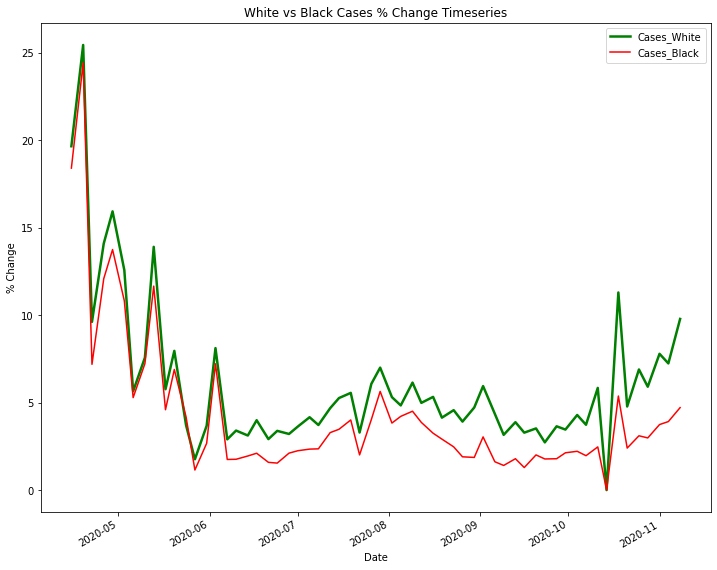

In [193]:
#Percent change for each CRDT data entry shift for White Cases vs Black Cases
cases_white = Indiana_CRDT[['Date','Cases_White']].sort_values(by='Date')
cases_white.set_index('Date', inplace=True)
cases_white=cases_white.astype('float64')
cases_white_pct=cases_white.pct_change()*100

cases_black = Indiana_CRDT[['Date','Cases_Black']].sort_values(by='Date')
cases_black.set_index('Date', inplace=True)
cases_black=cases_black.astype('float64')
cases_black_pct=cases_black.pct_change()*100

ax=cases_white_pct.plot(figsize=(12, 10), title='White vs Black Cases % Change Timeseries',linewidth=2.5, color='green'
                     ,ylabel='% Change',xlabel='Date')

dx=cases_black_pct.plot(ax=ax, color='red')

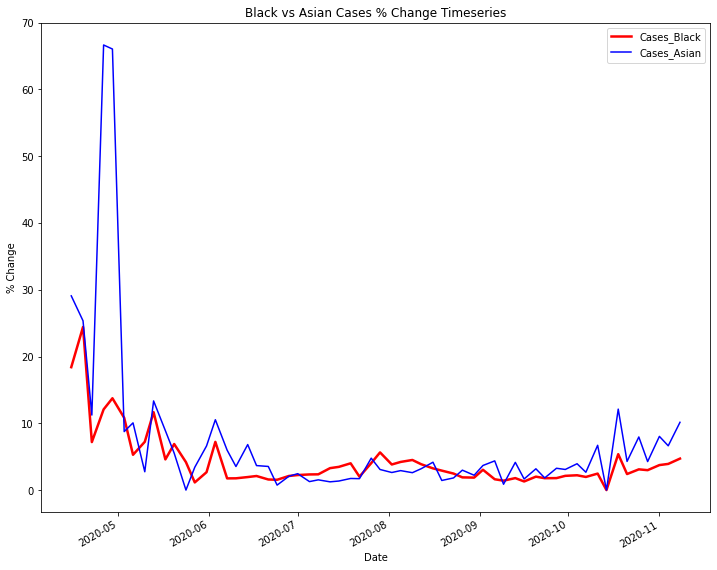

In [192]:
#Percent change for each CRDT data entry shift for Black Cases vs Asian Cases
cases_black = Indiana_CRDT[['Date','Cases_Black']].sort_values(by='Date')
cases_black.set_index('Date', inplace=True)
cases_black=cases_black.astype('float64')
cases_black_pct=cases_black.pct_change()*100

cases_asian = Indiana_CRDT[['Date','Cases_Asian']].sort_values(by='Date')
cases_asian.set_index('Date', inplace=True)
cases_asian=cases_asian.astype('float64')
cases_asian_pct=cases_asian.pct_change()*100

ax=cases_black_pct.plot(figsize=(12, 10), title='Black vs Asian Cases % Change Timeseries',linewidth=2.5, color='red'
                     ,ylabel='% Change',xlabel='Date')
dx=cases_asian_pct.plot(ax=ax, color='blue')

# Per Capita Bar Chart: Cases per 100k people

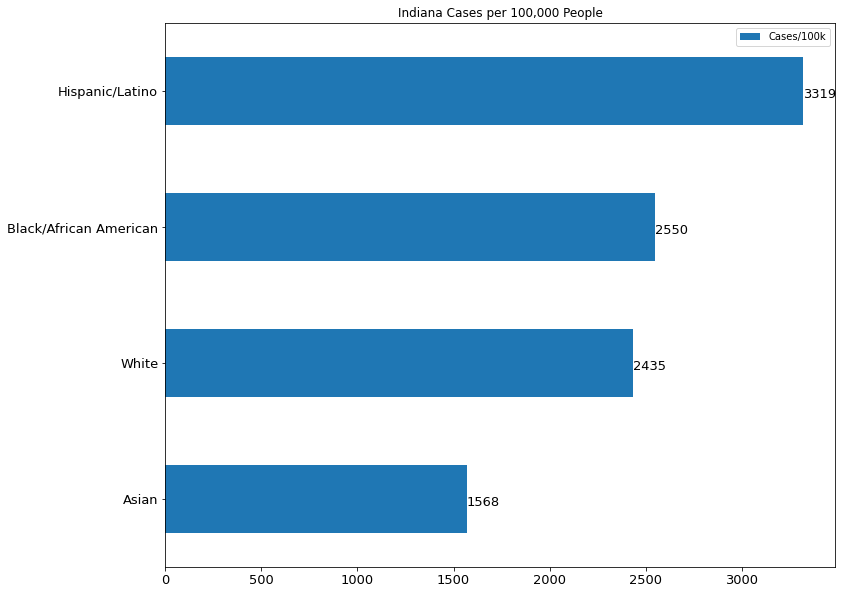

In [233]:
#Add a bar chart to see cases and deaths for each category for 100,000

#Taken from 2019 US Census will scrape in future. 
Asian_population=169824
Black_population=632503
Hispanic_population=485554
White_population=5272268

White_cases_per_cap=(Indiana_race.loc["White","Cases"]/White_population*100000).round()
Black_cases_per_cap=(Indiana_race.loc["Black or African American","Cases"]/Black_population*100000).round()
Hispanic_cases_per_cap=(Indiana_ethnicity.loc["Hispanic or Latino","Cases"]/Hispanic_population*100000).round()
Asian_cases_per_cap=(Indiana_race.loc["Asian","Cases"]/Asian_population*100000).round()

Cases_per_cap=pd.DataFrame({"Cases/100k":[White_cases_per_cap, Black_cases_per_cap,Hispanic_cases_per_cap,Asian_cases_per_cap]},
             index=["White","Black/African American","Hispanic/Latino","Asian"]).sort_values(by='Cases/100k', ascending=False)

ax=Cases_per_cap.plot.barh(figsize=(12, 10),title="Indiana Cases per 100,000 People",fontsize=13)

#this is so the graph can have the labels

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.3, \
            int((i.get_width())), fontsize=13,
color='black')

# invert for largest on top 
ax.invert_yaxis()

# Per Capital Bar Chart: Deaths per 100k people

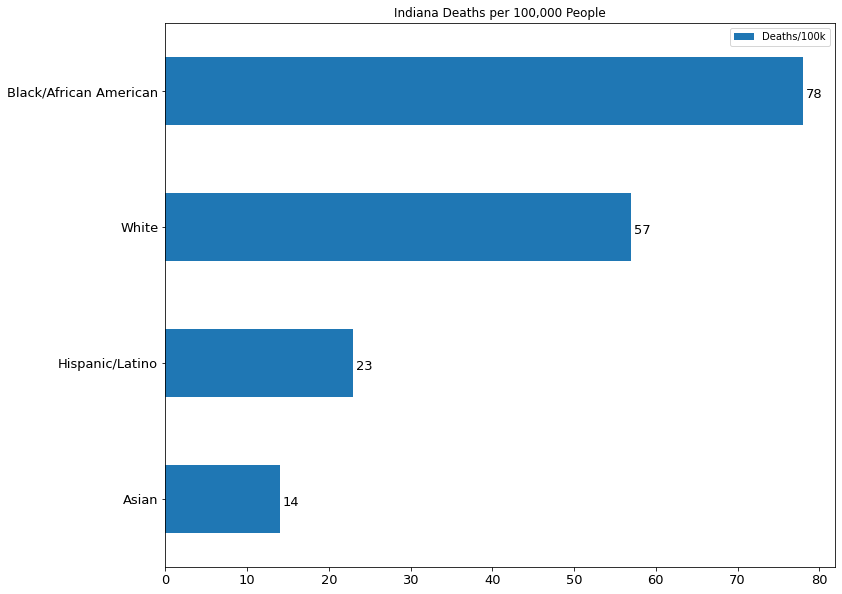

In [234]:
#Add a bar chart to see cases and deaths for each category for 100,000

#Taken from 2019 US Census will scrape in future. 
Asian_population=169824
Black_population=632503
Hispanic_population=485554
White_population=5272268

White_deaths_per_cap=(Indiana_race.loc["White","Deaths"]/White_population*100000).round()
Black_deaths_per_cap=(Indiana_race.loc["Black or African American","Deaths"]/Black_population*100000).round()
Hispanic_deaths_per_cap=(Indiana_ethnicity.loc["Hispanic or Latino","Deaths"]/Hispanic_population*100000).round()
Asian_deaths_per_cap=(Indiana_race.loc["Asian","Deaths"]/Asian_population*100000).round()

Cases_per_cap=pd.DataFrame({"Deaths/100k":[White_deaths_per_cap, Black_deaths_per_cap,Hispanic_deaths_per_cap,Asian_deaths_per_cap]},
             index=["White","Black/African American","Hispanic/Latino","Asian"]).sort_values(by='Deaths/100k',ascending=False)
ax=Cases_per_cap.plot.barh(figsize=(12, 10),title="Indiana Deaths per 100,000 People",fontsize=13)

#this is so the graph can have the labels

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.3, \
            int((i.get_width())), fontsize=13,
color='black')

# invert for largest on top 
ax.invert_yaxis()

# Summary Statistics for Percentage Change for Each Race and Ethnicity

In [107]:
Indiana_CRDT_Sorted=Indiana_CRDT.set_index('Date').sort_index()
Indiana_CRDT_Sorted=Indiana_CRDT_Sorted.astype('float64')
Indiana_CRDT_PCT=Indiana_CRDT_Sorted.pct_change()*100
Indiana_CRDT_PCT.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Cases_Total,60.0,5.703843,4.478276,1.642976,3.162875,4.263812,6.241703,25.209427
Cases_White,60.0,6.120795,4.364959,0.000000,3.642543,4.750742,6.920937,25.447628
Cases_Black,60.0,4.305953,4.266964,0.000000,1.961723,2.947325,4.529768,24.428934
Cases_LatinX,58.0,2.621377,11.948338,0.000000,0.000000,0.000000,0.000000,74.148607
Cases_Asian,60.0,7.178035,12.234849,0.000000,2.181282,3.532899,6.734378,66.666667
Cases_AIAN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cases_NHPI,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cases_Multiracial,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cases_Other,60.0,5.896671,6.228573,0.000000,2.695406,3.193340,5.272743,27.176781
Cases_Unknown,60.0,5.852714,12.838739,-17.471410,-0.959562,6.171992,9.302065,81.363904
